In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from math import ceil
from sklearn.metrics import accuracy_score, log_loss
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../training_utils/')
from data_utils import get_folders, get_class_weights
from train_utils import predict
from diagnostic_tools import top_k_accuracy, per_class_accuracy,\
    count_params, entropy, model_calibration, most_confused_classes,\
    most_inaccurate_k_classes
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterator

In [4]:
_, val_folder = get_folders()

val_iterator = DataLoader(
    val_folder, batch_size=64, num_workers=4,
    shuffle=False, pin_memory=True
)

# Load models

In [5]:
sys.path.append('../densenet/')
sys.path.append('../squeezenet/')

from get_densenet121 import get_model as get_densenet
from get_squeezenet import get_model as get_squeezenet

In [6]:
# decode: folder name to class name (in human readable format)
_, decode = get_class_weights(val_folder.class_to_idx)

# index to class name
decode = {val_folder.class_to_idx[k]: decode[int(k)] for k in val_folder.class_to_idx}

In [7]:
densenet, _, _ = get_densenet()
squeezenet, _, _ = get_squeezenet()

# load pretrained models
densenet.load_state_dict(torch.load('../densenet/model121.pytorch_state'))
squeezenet.load_state_dict(torch.load('../squeezenet/model.pytorch_state'))

In [8]:
# compare number of params
count_params(densenet)/count_params(squeezenet)

8.451690278090098

# Get all predictions

In [9]:
# predictions of densenet
val_predictions1, _ = predict(densenet, val_iterator)

# predictions of squeezenet
val_predictions2, val_true_targets = predict(squeezenet, val_iterator)

100%|██████████| 80/80 [00:05<00:00, 14.42it/s]


# Delegating classification

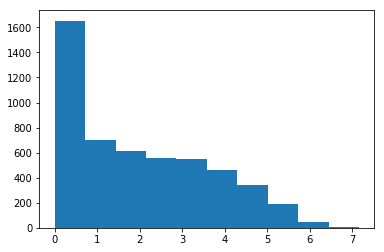

In [10]:
# entropy of squeezenet predictions
squeezenet_entropy = entropy(val_predictions2)
plt.hist(squeezenet_entropy);

In [11]:
threshold = 3.0

In [12]:
# fraction of images that we are delegating to densenet
(squeezenet_entropy > threshold).mean()

0.29023437499999999

In [13]:
val_predictions = np.zeros_like(val_predictions2)

# images with predictions that have high entropy we delegate to densenet
val_predictions[squeezenet_entropy > threshold] = val_predictions1[squeezenet_entropy > threshold]
# we use densenet ~29% of the time

# on the rest we use squeezenet
val_predictions[squeezenet_entropy <= threshold] = val_predictions2[squeezenet_entropy <= threshold]

# Analysis

### logloss and accuracies

In [14]:
log_loss(val_true_targets, val_predictions)

0.93835540544026175

In [15]:
# accuracy without delegation is 65%
accuracy_score(val_true_targets, val_predictions.argmax(1))

0.77128906249999996

In [16]:
print(top_k_accuracy(val_true_targets, val_predictions, k=(2, 3, 4, 5, 10)))

[0.86503906249999996, 0.90000000000000002, 0.91679687499999996, 0.92734375000000002, 0.95781249999999996]


### entropy of predictions

In [17]:
hits = val_predictions.argmax(1) == val_true_targets

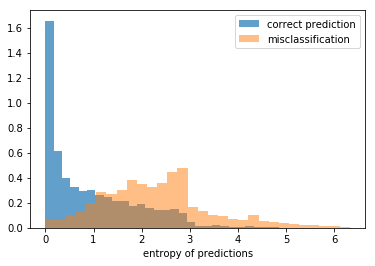

In [18]:
plt.hist(
    entropy(val_predictions[hits]), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    entropy(val_predictions[~hits]), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('entropy of predictions');

### confidence of predictions

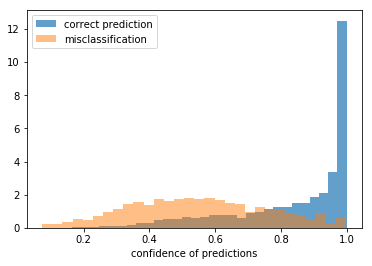

In [19]:
plt.hist(
    val_predictions[hits].max(1), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    val_predictions[~hits].max(1), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('confidence of predictions');

### difference between biggest and second biggest probability

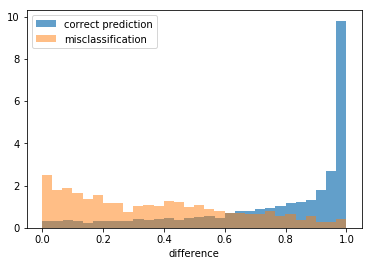

In [20]:
sorted_correct = np.sort(val_predictions[hits], 1)
sorted_incorrect = np.sort(val_predictions[~hits], 1)

plt.hist(
    sorted_correct[:, -1] - sorted_correct[:, -2], bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    sorted_incorrect[:, -1] - sorted_incorrect[:, -2], bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('difference');

### probabilistic calibration of the model

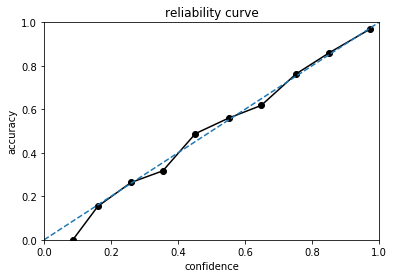

In [21]:
model_calibration(val_true_targets, val_predictions, n_bins=10)

### per class accuracies

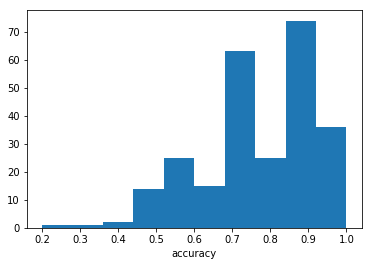

In [22]:
per_class_acc = per_class_accuracy(val_true_targets, val_predictions)
plt.hist(per_class_acc);
plt.xlabel('accuracy');

In [23]:
most_inaccurate_k_classes(per_class_acc, 15, decode)

drinking-straw 0.2
skateboard 0.35
ladder 0.4
frog 0.4
screwdriver 0.45
playing-card 0.45
cd 0.45
rifle 0.45
tambourine 0.45
minotaur 0.45
chopsticks 0.45
sneaker 0.45
baseball-bat 0.5
hot-dog 0.5
mussels 0.5


### most confused pairs of classes

In [24]:
confused_pairs = most_confused_classes(
    val_true_targets, val_predictions, decode, min_n_confusions=4
)
confused_pairs

[('ak47', 'rifle'),
 ('beer-mug', 'coffee-mug'),
 ('hibiscus', 'iris'),
 ('horse', 'dog'),
 ('house-fly', 'cockroach'),
 ('kayak', 'canoe'),
 ('killer-whale', 'dolphin'),
 ('laptop', 'computer-keyboard'),
 ('light-house', 'minaret'),
 ('mandolin', 'electric-guitar'),
 ('mountain-bike', 'touring-bike'),
 ('paper-shredder', 'washing-machine'),
 ('sneaker', 'tennis-shoes'),
 ('swan', 'goose'),
 ('syringe', 'flashlight'),
 ('yo-yo', 'frisbee'),
 ('toad', 'frog'),
 ('chimp', 'gorilla'),
 ('chopsticks', 'baseball-bat'),
 ('comet', 'galaxy'),
 ('cormorant', 'goose'),
 ('duck', 'goose'),
 ('frog', 'grasshopper')]